<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 7

# Student 1: Ambarish Moharil (1704818)

# Student 2: Kunal Geed (1736051)

# Student 3: Mert Lostar (1668846)

# Downloading Data and Preliminaries

In [63]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from zipfile import ZipFile
import requests
import io
import torch_geometric
from torch import nn
from torch_geometric.nn import SAGEConv
from torch.utils.data import Dataset, DataLoader,TensorDataset

In [64]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [65]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [66]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [67]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [68]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

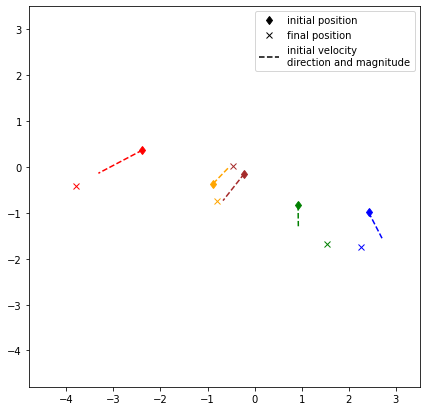

In [69]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [70]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [206]:

class DatasetClass(Dataset):
    def __init__(self, positions, velocities,charges,t):
        t_horizons = [0,0.5,1,1.5]
        t_idx = t_horizons.index(t)
        (samples,seq_length,dim,length) = positions.shape
        # Get the initial positions
        init_pos = positions[:,0,:,:]
        init_pos = init_pos.reshape(samples,dim*length) # Flatten x,y to a single list [x1,x2...,x5,y1,y2...,y5]
        # Get the initial velocities
        init_vel = velocities.reshape(samples,dim*length) # Flatten x,y to a single list [x1,x2...,x5,y1,y2...,y5]
        # Get the charges
        c = charges.reshape(samples,length) # Flatten (samples,1,length) -> (samples,length)
        # Create the feature array using initial state
        features = np.concatenate((init_pos,init_vel,c),axis=1) # Concatenate initial information to a feature array
        
        #Create targets using positions in timesteps after the initial one and flattening the dimensions to a single list
        #targets = np.array([positions[idx,t,:,:] for idx in range(len(target_ids))]).reshape(samples,length*dim)
        targets = positions[:,t_idx,:,:].reshape(samples,length*dim)
        self.data = torch.FloatTensor(features)
        #print(self.data.shape)
        self.targets = torch.FloatTensor(targets)
        
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [192]:

def create_graphset(positions, velocities,charges,t,sample_size,batch_size):
        t_horizons = [0,0.5,1,1.5]
        t_idx = t_horizons.index(t)
        (samples,seq_length,dim,length) = positions.shape
        # Get the initial positions
        init_pos = positions[:sample_size,0,:,:]
        init_pos = init_pos.reshape(sample_size,length,dim) # (Samples,n,2)
        # Get the initial velocities
        init_vel = velocities[:sample_size]
        init_vel = init_vel.reshape(sample_size,length,dim) # (Samples,n,2)
        # Get the charges
        c = charges[:sample_size]
        c = c.reshape(sample_size,length,1) # Reshape (samples,length) -> (samples,length,1) for compatibility
        src = []
        tgt = []
        for i in range(length):
           for j in range(length):
              src.append(i)
              tgt.append(j)
            
        # Same generic edge index for every simulation
        edge_index = torch.LongTensor([src,tgt])
        features_array = []
        data = []
        batches = []
        batch_counter = 0
        targets = np.array([positions[idx,t_idx,:,:] for idx in range(sample_size)]).reshape(sample_size,length,dim)
        features = np.concatenate((init_pos,init_vel,c,np.broadcast_to(t,(sample_size,length,1))),axis=2) # Concatenate initial information to a feature array
        
            
        # Create the feature array using initial state
        #print(features.shape)
        #print(targets.shape)
        features = torch.FloatTensor(features)
        for sim_id in range(features.shape[0]):
            data.append(torch_geometric.data.Data(x=features[sim_id],edge_index=edge_index,num_nodes = features.shape[1]))
            batch_counter+=1
            if batch_counter == batch_size:
                batch = torch_geometric.data.Batch.from_data_list(data)
                batches.append(batch)
                data = []
                batch_counter = 0
        #Create targets using positions in timesteps after the initial one and flattening the dimensions to a single list
        
        #data = torch.FloatTensor(features)
        targets = torch.FloatTensor(targets.reshape(len(batches),length*batch_size,dim))
        #print(targets.shape)
        return batches,targets

# Model Implementation

In [76]:

class PhysicsSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim,device):
        super(PhysicsSAGE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
    
        self.sage = SAGEConv(in_channels=input_dim,
                       out_channels=hidden_dim)
        self.drop = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, output_dim)
        
    def forward(self, batch_data,batch_edge_index):
        
        embedding = self.sage(batch_data,batch_edge_index)
        embedding = self.drop(embedding)
        h1 = nn.ReLU()(self.fc1(embedding))
        #h1 = self.drop(h1)
        output = self.fc2(h1)
        
        
        return output
    

# Model Training

In [120]:
def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [124]:
# training and validation after every epoch
def train_graph(model,
                criterion, num_epochs, model_name):
    all_train_losses= {}
    all_val_losses = {}
    
    for sample_size in [100,1000,10000]:
        for t in [0.5,1,1.5]:
            save_name = f"{model_name}_{sample_size}_{t}_.pt"
            train_data,train_targets= create_graphset(positions_train,velocities_train,charges_train,
                                                                  t,sample_size,batch_size=sample_size//10)
            val_data,val_targets = create_graphset(positions_valid,velocities_valid,charges_valid,
                                                                   t,2000,batch_size=20)
            

            best_val_loss = float("Inf") 
            train_losses = []
            val_losses = []
            cur_step = 0


            for epoch in range(num_epochs):
                model.train()
                print("Starting epoch " + str(epoch+1))
                running_loss = 0.0
                for batch_idx,batch in enumerate(train_data):
                    # Forward
                    outputs = model.forward(batch.x.to(device),
                                           batch.edge_index.to(device))
                    #print(outputs.shape)
                    loss = criterion(outputs,train_targets[batch_idx].to(device))
                    # Backward and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()   
                    running_loss += loss

                avg_train_loss = running_loss / len(train_data)
                train_losses.append(avg_train_loss)
                print("Train Pass Completed")

                ########################################|Validation Set|#############################################
                val_running_loss = 0.0
                with torch.no_grad():
                    model.eval()
                    for batch_idx,batch in enumerate(val_data):
                        outputs = model.forward(batch.x.to(device),
                                           batch.edge_index.to(device))
                        loss = criterion(outputs,val_targets[batch_idx].to(device))
                        val_running_loss += loss

                    avg_val_loss = val_running_loss / len(val_data)
                    val_losses.append(avg_val_loss)


                print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
                    .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss 
                    save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
                print("Finished Training") 
                all_train_losses[save_name] = train_losses
                all_val_losses[save_name] = val_losses
    return all_train_losses, all_val_losses
     

In [125]:
p_sage = PhysicsSAGE(6,192,2,device='cuda:0').cuda()

optimizer = torch.optim.SGD(p_sage.parameters(), lr=0.01, momentum=0.9)
num_epochs = 100
model_name = f'p_sage'
criterion = nn.MSELoss()

obtained_train_loss_psage, obtained_val_loss_psage = train_graph(p_sage,                                   
                                                      criterion, num_epochs, model_name)

Starting epoch 1
Train Pass Completed
Epoch [1/100],Train Loss: 3.3235, Valid Loss: 2.38322687
Model Saved to ==> p_sage_100_0.5_.pt
Finished Training
Starting epoch 2
Train Pass Completed
Epoch [2/100],Train Loss: 2.0835, Valid Loss: 1.52200925
Model Saved to ==> p_sage_100_0.5_.pt
Finished Training
Starting epoch 3
Train Pass Completed
Epoch [3/100],Train Loss: 1.2092, Valid Loss: 0.73147565
Model Saved to ==> p_sage_100_0.5_.pt
Finished Training
Starting epoch 4
Train Pass Completed
Epoch [4/100],Train Loss: 0.7465, Valid Loss: 0.39265230
Model Saved to ==> p_sage_100_0.5_.pt
Finished Training
Starting epoch 5
Train Pass Completed
Epoch [5/100],Train Loss: 0.6868, Valid Loss: 0.44403028
Finished Training
Starting epoch 6
Train Pass Completed
Epoch [6/100],Train Loss: 0.5533, Valid Loss: 0.30655137
Model Saved to ==> p_sage_100_0.5_.pt
Finished Training
Starting epoch 7
Train Pass Completed
Epoch [7/100],Train Loss: 0.3855, Valid Loss: 0.43227580
Finished Training
Starting epoch 8
Tr

Epoch [68/100],Train Loss: 0.1197, Valid Loss: 0.08135193
Finished Training
Starting epoch 69
Train Pass Completed
Epoch [69/100],Train Loss: 0.1190, Valid Loss: 0.07694335
Finished Training
Starting epoch 70
Train Pass Completed
Epoch [70/100],Train Loss: 0.1227, Valid Loss: 0.05863671
Finished Training
Starting epoch 71
Train Pass Completed
Epoch [71/100],Train Loss: 0.1098, Valid Loss: 0.06052391
Finished Training
Starting epoch 72
Train Pass Completed
Epoch [72/100],Train Loss: 0.1067, Valid Loss: 0.05660266
Finished Training
Starting epoch 73
Train Pass Completed
Epoch [73/100],Train Loss: 0.1007, Valid Loss: 0.05828573
Finished Training
Starting epoch 74
Train Pass Completed
Epoch [74/100],Train Loss: 0.1141, Valid Loss: 0.05611124
Finished Training
Starting epoch 75
Train Pass Completed
Epoch [75/100],Train Loss: 0.1229, Valid Loss: 0.07113219
Finished Training
Starting epoch 76
Train Pass Completed
Epoch [76/100],Train Loss: 0.1089, Valid Loss: 0.06435151
Finished Training
Star

Epoch [37/100],Train Loss: 0.2528, Valid Loss: 0.17800771
Finished Training
Starting epoch 38
Train Pass Completed
Epoch [38/100],Train Loss: 0.2256, Valid Loss: 0.18764468
Finished Training
Starting epoch 39
Train Pass Completed
Epoch [39/100],Train Loss: 0.2294, Valid Loss: 0.13850480
Model Saved to ==> p_sage_100_1_.pt
Finished Training
Starting epoch 40
Train Pass Completed
Epoch [40/100],Train Loss: 0.2022, Valid Loss: 0.17207915
Finished Training
Starting epoch 41
Train Pass Completed
Epoch [41/100],Train Loss: 0.2072, Valid Loss: 0.14428316
Finished Training
Starting epoch 42
Train Pass Completed
Epoch [42/100],Train Loss: 0.1969, Valid Loss: 0.16427118
Finished Training
Starting epoch 43
Train Pass Completed
Epoch [43/100],Train Loss: 0.2075, Valid Loss: 0.14586823
Finished Training
Starting epoch 44
Train Pass Completed
Epoch [44/100],Train Loss: 0.1907, Valid Loss: 0.16895080
Finished Training
Starting epoch 45
Train Pass Completed
Epoch [45/100],Train Loss: 0.1936, Valid Los

Epoch [8/100],Train Loss: 0.3211, Valid Loss: 0.28460154
Finished Training
Starting epoch 9
Train Pass Completed
Epoch [9/100],Train Loss: 0.3298, Valid Loss: 0.29412523
Finished Training
Starting epoch 10
Train Pass Completed
Epoch [10/100],Train Loss: 0.3446, Valid Loss: 0.32049412
Finished Training
Starting epoch 11
Train Pass Completed
Epoch [11/100],Train Loss: 0.3694, Valid Loss: 0.30258843
Finished Training
Starting epoch 12
Train Pass Completed
Epoch [12/100],Train Loss: 0.3677, Valid Loss: 0.29028580
Finished Training
Starting epoch 13
Train Pass Completed
Epoch [13/100],Train Loss: 0.3551, Valid Loss: 0.39973322
Finished Training
Starting epoch 14
Train Pass Completed
Epoch [14/100],Train Loss: 0.4216, Valid Loss: 0.43114460
Finished Training
Starting epoch 15
Train Pass Completed
Epoch [15/100],Train Loss: 0.5205, Valid Loss: 0.33981830
Finished Training
Starting epoch 16
Train Pass Completed
Epoch [16/100],Train Loss: 0.5199, Valid Loss: 0.37620860
Finished Training
Startin

Epoch [79/100],Train Loss: 0.3976, Valid Loss: 0.37864551
Finished Training
Starting epoch 80
Train Pass Completed
Epoch [80/100],Train Loss: 0.5027, Valid Loss: 0.45448199
Finished Training
Starting epoch 81
Train Pass Completed
Epoch [81/100],Train Loss: 0.4354, Valid Loss: 0.51487690
Finished Training
Starting epoch 82
Train Pass Completed
Epoch [82/100],Train Loss: 0.4166, Valid Loss: 0.36816365
Finished Training
Starting epoch 83
Train Pass Completed
Epoch [83/100],Train Loss: 0.3414, Valid Loss: 0.35073909
Finished Training
Starting epoch 84
Train Pass Completed
Epoch [84/100],Train Loss: 0.2988, Valid Loss: 0.30007911
Finished Training
Starting epoch 85
Train Pass Completed
Epoch [85/100],Train Loss: 0.3273, Valid Loss: 0.37103271
Finished Training
Starting epoch 86
Train Pass Completed
Epoch [86/100],Train Loss: 0.3634, Valid Loss: 0.38886055
Finished Training
Starting epoch 87
Train Pass Completed
Epoch [87/100],Train Loss: 0.4000, Valid Loss: 0.32013446
Finished Training
Star

Epoch [43/100],Train Loss: 0.0732, Valid Loss: 0.03026719
Finished Training
Starting epoch 44
Train Pass Completed
Epoch [44/100],Train Loss: 0.0725, Valid Loss: 0.02736405
Model Saved to ==> p_sage_1000_0.5_.pt
Finished Training
Starting epoch 45
Train Pass Completed
Epoch [45/100],Train Loss: 0.0714, Valid Loss: 0.02814626
Finished Training
Starting epoch 46
Train Pass Completed
Epoch [46/100],Train Loss: 0.0705, Valid Loss: 0.02932093
Finished Training
Starting epoch 47
Train Pass Completed
Epoch [47/100],Train Loss: 0.0723, Valid Loss: 0.02768397
Finished Training
Starting epoch 48
Train Pass Completed
Epoch [48/100],Train Loss: 0.0735, Valid Loss: 0.02729028
Model Saved to ==> p_sage_1000_0.5_.pt
Finished Training
Starting epoch 49
Train Pass Completed
Epoch [49/100],Train Loss: 0.0700, Valid Loss: 0.02766538
Finished Training
Starting epoch 50
Train Pass Completed
Epoch [50/100],Train Loss: 0.0730, Valid Loss: 0.02923346
Finished Training
Starting epoch 51
Train Pass Completed
Ep

Epoch [10/100],Train Loss: 0.1429, Valid Loss: 0.09717724
Finished Training
Starting epoch 11
Train Pass Completed
Epoch [11/100],Train Loss: 0.1417, Valid Loss: 0.09834740
Finished Training
Starting epoch 12
Train Pass Completed
Epoch [12/100],Train Loss: 0.1447, Valid Loss: 0.10048418
Finished Training
Starting epoch 13
Train Pass Completed
Epoch [13/100],Train Loss: 0.1418, Valid Loss: 0.09686618
Finished Training
Starting epoch 14
Train Pass Completed
Epoch [14/100],Train Loss: 0.1416, Valid Loss: 0.09544550
Model Saved to ==> p_sage_1000_1_.pt
Finished Training
Starting epoch 15
Train Pass Completed
Epoch [15/100],Train Loss: 0.1439, Valid Loss: 0.09716802
Finished Training
Starting epoch 16
Train Pass Completed
Epoch [16/100],Train Loss: 0.1429, Valid Loss: 0.09498706
Model Saved to ==> p_sage_1000_1_.pt
Finished Training
Starting epoch 17
Train Pass Completed
Epoch [17/100],Train Loss: 0.1385, Valid Loss: 0.09363823
Model Saved to ==> p_sage_1000_1_.pt
Finished Training
Starting

Epoch [79/100],Train Loss: 0.1399, Valid Loss: 0.09584560
Finished Training
Starting epoch 80
Train Pass Completed
Epoch [80/100],Train Loss: 0.1372, Valid Loss: 0.09459325
Finished Training
Starting epoch 81
Train Pass Completed
Epoch [81/100],Train Loss: 0.1356, Valid Loss: 0.09410563
Finished Training
Starting epoch 82
Train Pass Completed
Epoch [82/100],Train Loss: 0.1388, Valid Loss: 0.09225240
Finished Training
Starting epoch 83
Train Pass Completed
Epoch [83/100],Train Loss: 0.1380, Valid Loss: 0.09223200
Finished Training
Starting epoch 84
Train Pass Completed
Epoch [84/100],Train Loss: 0.1351, Valid Loss: 0.09145509
Finished Training
Starting epoch 85
Train Pass Completed
Epoch [85/100],Train Loss: 0.1373, Valid Loss: 0.09457894
Finished Training
Starting epoch 86
Train Pass Completed
Epoch [86/100],Train Loss: 0.1387, Valid Loss: 0.09336606
Finished Training
Starting epoch 87
Train Pass Completed
Epoch [87/100],Train Loss: 0.1354, Valid Loss: 0.09159563
Finished Training
Star

Epoch [47/100],Train Loss: 0.2466, Valid Loss: 0.20275167
Finished Training
Starting epoch 48
Train Pass Completed
Epoch [48/100],Train Loss: 0.2450, Valid Loss: 0.20187366
Finished Training
Starting epoch 49
Train Pass Completed
Epoch [49/100],Train Loss: 0.2462, Valid Loss: 0.20113178
Finished Training
Starting epoch 50
Train Pass Completed
Epoch [50/100],Train Loss: 0.2464, Valid Loss: 0.20217186
Finished Training
Starting epoch 51
Train Pass Completed
Epoch [51/100],Train Loss: 0.2496, Valid Loss: 0.20347905
Finished Training
Starting epoch 52
Train Pass Completed
Epoch [52/100],Train Loss: 0.2481, Valid Loss: 0.20742266
Finished Training
Starting epoch 53
Train Pass Completed
Epoch [53/100],Train Loss: 0.2463, Valid Loss: 0.20404734
Finished Training
Starting epoch 54
Train Pass Completed
Epoch [54/100],Train Loss: 0.2504, Valid Loss: 0.20378420
Finished Training
Starting epoch 55
Train Pass Completed
Epoch [55/100],Train Loss: 0.2459, Valid Loss: 0.20541313
Finished Training
Star

Epoch [15/100],Train Loss: 0.0680, Valid Loss: 0.02881512
Model Saved to ==> p_sage_10000_0.5_.pt
Finished Training
Starting epoch 16
Train Pass Completed
Epoch [16/100],Train Loss: 0.0683, Valid Loss: 0.02909432
Finished Training
Starting epoch 17
Train Pass Completed
Epoch [17/100],Train Loss: 0.0676, Valid Loss: 0.02853913
Model Saved to ==> p_sage_10000_0.5_.pt
Finished Training
Starting epoch 18
Train Pass Completed
Epoch [18/100],Train Loss: 0.0677, Valid Loss: 0.02858875
Finished Training
Starting epoch 19
Train Pass Completed
Epoch [19/100],Train Loss: 0.0673, Valid Loss: 0.02844132
Model Saved to ==> p_sage_10000_0.5_.pt
Finished Training
Starting epoch 20
Train Pass Completed
Epoch [20/100],Train Loss: 0.0674, Valid Loss: 0.02807721
Model Saved to ==> p_sage_10000_0.5_.pt
Finished Training
Starting epoch 21
Train Pass Completed
Epoch [21/100],Train Loss: 0.0669, Valid Loss: 0.02789783
Model Saved to ==> p_sage_10000_0.5_.pt
Finished Training
Starting epoch 22
Train Pass Compl

Train Pass Completed
Epoch [79/100],Train Loss: 0.0616, Valid Loss: 0.02552337
Finished Training
Starting epoch 80
Train Pass Completed
Epoch [80/100],Train Loss: 0.0618, Valid Loss: 0.02532786
Finished Training
Starting epoch 81
Train Pass Completed
Epoch [81/100],Train Loss: 0.0612, Valid Loss: 0.02558973
Finished Training
Starting epoch 82
Train Pass Completed
Epoch [82/100],Train Loss: 0.0608, Valid Loss: 0.02570077
Finished Training
Starting epoch 83
Train Pass Completed
Epoch [83/100],Train Loss: 0.0602, Valid Loss: 0.02500623
Model Saved to ==> p_sage_10000_0.5_.pt
Finished Training
Starting epoch 84
Train Pass Completed
Epoch [84/100],Train Loss: 0.0611, Valid Loss: 0.02561573
Finished Training
Starting epoch 85
Train Pass Completed
Epoch [85/100],Train Loss: 0.0611, Valid Loss: 0.02571029
Finished Training
Starting epoch 86
Train Pass Completed
Epoch [86/100],Train Loss: 0.0613, Valid Loss: 0.02540328
Finished Training
Starting epoch 87
Train Pass Completed
Epoch [87/100],Trai

Epoch [43/100],Train Loss: 0.1351, Valid Loss: 0.08926034
Finished Training
Starting epoch 44
Train Pass Completed
Epoch [44/100],Train Loss: 0.1339, Valid Loss: 0.08863051
Finished Training
Starting epoch 45
Train Pass Completed
Epoch [45/100],Train Loss: 0.1347, Valid Loss: 0.08886138
Finished Training
Starting epoch 46
Train Pass Completed
Epoch [46/100],Train Loss: 0.1351, Valid Loss: 0.08840258
Finished Training
Starting epoch 47
Train Pass Completed
Epoch [47/100],Train Loss: 0.1343, Valid Loss: 0.08804173
Model Saved to ==> p_sage_10000_1_.pt
Finished Training
Starting epoch 48
Train Pass Completed
Epoch [48/100],Train Loss: 0.1348, Valid Loss: 0.08827616
Finished Training
Starting epoch 49
Train Pass Completed
Epoch [49/100],Train Loss: 0.1339, Valid Loss: 0.08840096
Finished Training
Starting epoch 50
Train Pass Completed
Epoch [50/100],Train Loss: 0.1349, Valid Loss: 0.08828359
Finished Training
Starting epoch 51
Train Pass Completed
Epoch [51/100],Train Loss: 0.1349, Valid L

Train Pass Completed
Epoch [12/100],Train Loss: 0.2526, Valid Loss: 0.19553290
Model Saved to ==> p_sage_10000_1.5_.pt
Finished Training
Starting epoch 13
Train Pass Completed
Epoch [13/100],Train Loss: 0.2526, Valid Loss: 0.19577369
Finished Training
Starting epoch 14
Train Pass Completed
Epoch [14/100],Train Loss: 0.2523, Valid Loss: 0.19606775
Finished Training
Starting epoch 15
Train Pass Completed
Epoch [15/100],Train Loss: 0.2538, Valid Loss: 0.19425312
Model Saved to ==> p_sage_10000_1.5_.pt
Finished Training
Starting epoch 16
Train Pass Completed
Epoch [16/100],Train Loss: 0.2536, Valid Loss: 0.19456980
Finished Training
Starting epoch 17
Train Pass Completed
Epoch [17/100],Train Loss: 0.2536, Valid Loss: 0.19410722
Model Saved to ==> p_sage_10000_1.5_.pt
Finished Training
Starting epoch 18
Train Pass Completed
Epoch [18/100],Train Loss: 0.2533, Valid Loss: 0.19331384
Model Saved to ==> p_sage_10000_1.5_.pt
Finished Training
Starting epoch 19
Train Pass Completed
Epoch [19/100]

Epoch [80/100],Train Loss: 0.2492, Valid Loss: 0.19267985
Finished Training
Starting epoch 81
Train Pass Completed
Epoch [81/100],Train Loss: 0.2486, Valid Loss: 0.19304419
Finished Training
Starting epoch 82
Train Pass Completed
Epoch [82/100],Train Loss: 0.2477, Valid Loss: 0.19303295
Finished Training
Starting epoch 83
Train Pass Completed
Epoch [83/100],Train Loss: 0.2486, Valid Loss: 0.19312944
Finished Training
Starting epoch 84
Train Pass Completed
Epoch [84/100],Train Loss: 0.2496, Valid Loss: 0.19329225
Finished Training
Starting epoch 85
Train Pass Completed
Epoch [85/100],Train Loss: 0.2486, Valid Loss: 0.19417976
Finished Training
Starting epoch 86
Train Pass Completed
Epoch [86/100],Train Loss: 0.2496, Valid Loss: 0.19308105
Finished Training
Starting epoch 87
Train Pass Completed
Epoch [87/100],Train Loss: 0.2481, Valid Loss: 0.19250715
Finished Training
Starting epoch 88
Train Pass Completed
Epoch [88/100],Train Loss: 0.2483, Valid Loss: 0.19301680
Finished Training
Star

{'p_sage_100_0.5_.pt': [tensor(3.3235, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(2.0835, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.2092, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7465, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6868, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.5533, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.3855, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4516, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4023, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.3261, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.2839, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.2491, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.2718, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.2190, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.2160, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1918, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1808, device='cuda:0', 

# Evaluation

In [196]:
#todo
# Baseline model
def baseline_predictor(inputs,t):
    # The same input [samples,25]
    initial_pos = inputs[:,:10]
    initial_vel = inputs[:,10:20]
    return initial_pos + initial_vel * t 

In [208]:
#Evaluating on the validation set
from sklearn.metrics import mean_squared_error
import pandas as pd
def evaluate_graph(model,device='cpu'):
    test_results = []
    for sample_size in [100,1000,10000]:
        for t in [0.5,1,1.5]:
            val_running_loss = 0.0
            test_data,test_targets = create_graphset(positions_test,velocities_test,charges_test,
                                                                 t,2000,batch_size=20)
            checkpoint = torch.load(f'p_sage_{sample_size}_{t}_.pt', map_location = 'cpu')
            model.load_state_dict(checkpoint['model_dict'])
            criterion = nn.MSELoss()
            with torch.no_grad():
                model.eval()
                for batch_idx,batch in enumerate(test_data):
                    outputs = model.forward(batch.x.to(device),
                                       batch.edge_index.to(device))
                    loss = criterion(outputs,test_targets[batch_idx].to(device))
                    val_running_loss += loss

                avg_val_loss = val_running_loss / len(test_data)
                test_results.append({'Train Set Size':sample_size,'t':t,'Test Loss (MSE)':avg_val_loss.item()})
    return test_results
# Train on t and try to predict t+0.5 in test set
def extra_experiment(model,device='cpu'):
    test_results = []
    for sample_size in [100,1000,10000]:
        for t in [0.5,1]:
            val_running_loss = 0.0
            test_data,test_targets = create_graphset(positions_test,velocities_test,charges_test,
                                                                 t+0.5,2000,batch_size=20)
            checkpoint = torch.load(f'p_sage_{sample_size}_{t}_.pt', map_location = 'cpu')
            model.load_state_dict(checkpoint['model_dict'])
            criterion = nn.MSELoss()
            with torch.no_grad():
                model.eval()
                for batch_idx,batch in enumerate(test_data):
                    outputs = model.forward(batch.x.to(device),
                                       batch.edge_index.to(device))
                    loss = criterion(outputs,test_targets[batch_idx].to(device))
                    val_running_loss += loss

                avg_val_loss = val_running_loss / len(test_data)
                test_results.append({'Train Set Size':sample_size,'t':t+0.5,'Test Loss (MSE)':avg_val_loss.item()})
    return test_results

def evaluate_baseline():
    test_results = []
    for t in [0.5,1,1.5]:
        
        test_running_loss = 0
        batch_size =20
        test_dataset = DatasetClass(positions_test, velocities_test, charges_test,t)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
        batch_id = 0
        for test_data,test_target in test_loader:
            test_data = test_data.numpy()
            test_target = test_target.numpy()
            predictions = baseline_predictor(test_data,t)
            loss = mean_squared_error(test_target,predictions)
            test_running_loss += loss
            batch_id+=1
        avg_test_loss = test_running_loss / len(test_loader)
        test_results.append(avg_test_loss)
    return test_results
    

In [184]:

#Model Evaluation
model = PhysicsSAGE(6,192,2,'cpu')

test_results = evaluate_graph(model)
extra_experiment_results = extra_experiment(model)

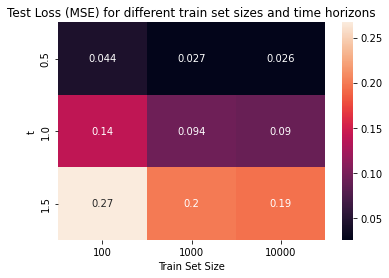

In [185]:
import seaborn as sns
df = pd.DataFrame(test_results)
pt = pd.pivot_table(df,values='Test Loss (MSE)',index='t',columns='Train Set Size')
ax = plt.axes()
sns.heatmap(pd.DataFrame(pt),annot=True,ax = ax)
ax.set_title('Test Loss (MSE) for different train set sizes and time horizons')
plt.show()

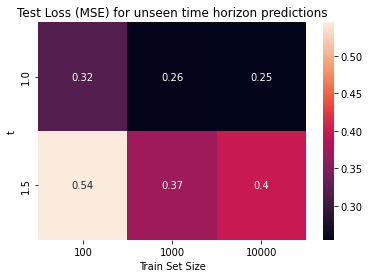

In [187]:
import seaborn as sns
df = pd.DataFrame(extra_experiment_results)
pt = pd.pivot_table(df,values='Test Loss (MSE)',index='t',columns='Train Set Size')
ax = plt.axes()
sns.heatmap(pd.DataFrame(pt),annot=True,ax = ax)
ax.set_title('Test Loss (MSE) for unseen time horizon predictions')
plt.show()

In [209]:
evaluate_baseline()

[0.05790466632694006, 0.25876864612102507, 0.6070641560852528]